In [ ]:
#| default_exp data.transform

# Transform

> Utility function to transform features and target

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|export
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from fastcore.test import *

from mirzai.data.loading import load_kssl
from mirzai.vis.core import plot_spectra

## Target variable

In [ ]:
#|export
def log_transform_y(data:tuple # (X, y, X_id, depth_order)
                   ):
    """
    Log-10 transform of the target value

    Takes and returns all (X, y, X_id, depth_order) tuple to be able to pipe the function
    """
    X, y, X_id, depth_order = data
    y = np.log10(y)
    return X, y, X_id, depth_order

## Features (spectra)

In [ ]:
#|export
CO2_REGION = [2389,  2269]

In [ ]:
#|export
class TakeDerivative(BaseEstimator, TransformerMixin):
    """Creates scikit-learn derivation custom transformer

    Args:
        window_length: int, optional
            Specify savgol filter smoothing window length

        polyorder: int, optional
            Specify order of the polynom used to interpolate derived signal

        deriv: int, optional
            Specify derivation degree

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self, window_length=11, polyorder=1, deriv=1):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return savgol_filter(X, self.window_length, self.polyorder, self.deriv)

In [ ]:
src_dir = 'test'
fnames = ['spectra-features-smp.npy', 'spectra-wavenumbers-smp.npy', 
          'depth-order-smp.npy', 'target-smp.npy', 
          'tax-order-lu-smp.pkl', 'spectra-id-smp.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

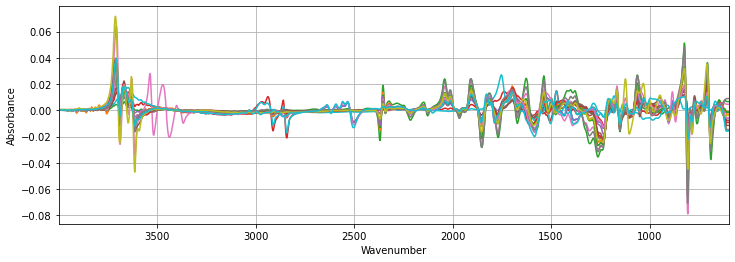

In [ ]:
tfm = TakeDerivative()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
#|export
class SNV(BaseEstimator, TransformerMixin):
    """Creates scikit-learn SNV custom transformer

    Args:
        None

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        mean, std = np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)
        return (X - mean)/std

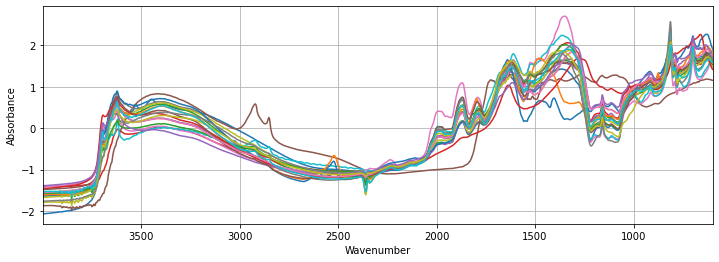

In [ ]:
tfm = SNV()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
class Center(BaseEstimator, TransformerMixin):
    """Creates scikit-learn Centering custom transformer

    Args:
        None

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X - np.mean(X, axis=1).reshape(-1, 1)

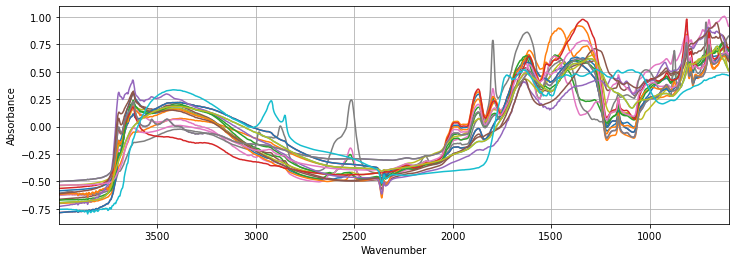

In [ ]:
tfm = Center()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
#|export
class DropSpectralRegions(BaseEstimator, TransformerMixin):
    """Creates scikit-learn custom transformer dropping specific spectral region(s)

    Args:
        wavenumbers: list
            List of wavenumbers where absorbance measured

        regions: list
            List of region(s) to drop

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self, wavenumbers, regions=[2389, 2269]):
        self.wavenumbers = wavenumbers
        self.regions = regions

    def _sanitize(self, regions):
        nb_regions = len(np.array(regions).shape)
        return np.array([regions]) if nb_regions == 1 else np.array(regions)

    def _exists(self, wavenumbers, regions):
        for wn in regions.flatten():
            assert wn in wavenumbers, 'Wavenumber "{}" does not exist'.format(wn)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        regions = self._sanitize(self.regions)
        X_transformed = np.copy(X)
        self._exists(self.wavenumbers, regions)
        for region in regions:
            high, low = region
            mask = (self.wavenumbers <= high) & (self.wavenumbers >= low)
            X_transformed[:, mask] = 0

        return X_transformed

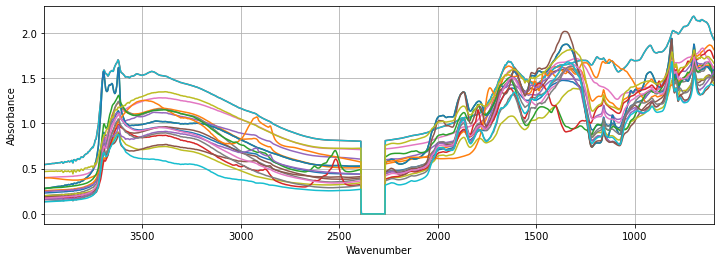

In [ ]:
tfm = DropSpectralRegions(X_names, regions=CO2_REGION)
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))